# Recommendations with IBM



## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import string
import re


import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>


In [3]:
number_of_users = df['email'].nunique()
print("There are {} users.".format(number_of_users))

There are 5148 users.


In [4]:
# Number of articles each email has interacted with 
user_interact = df[['email','article_id']].groupby(['email']).count() 
# Make sure we didnt lose anybody 
print('We still have {} users.'.format(len(user_interact)))

user_interact.describe()

We still have 5148 users.


,article_id
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


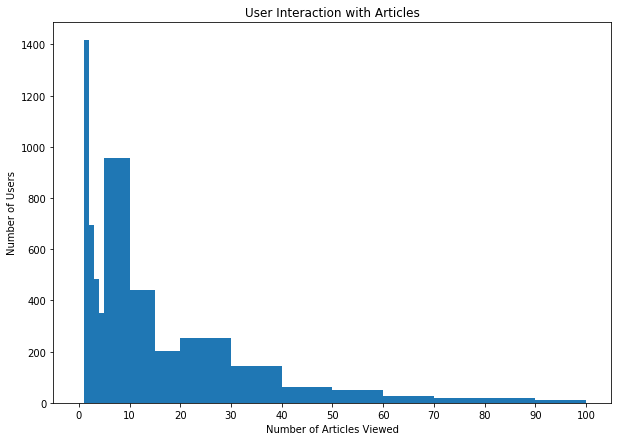

In [5]:
# Creates histogram of number of articles users have seen 
bins = [0,1,2,3,4,5,10,15,20,30,40,50,60,70,80,90,100]
xticks = [0,10,20,30,40,50,60,70,80,90,100]
plt.figure(figsize=(10,7))
plt.hist(user_interact['article_id'], bins = bins);
plt.ylabel('Number of Users');
plt.xlabel('Number of Articles Viewed');
plt.title('User Interaction with Articles');
plt.xticks(xticks);

##### From this histogram we can see that the data is clearly right skewed with most users having viewed less than 10 articles

In [6]:
# Median, mean, max
median_val = user_interact['article_id'].median();
mean_val = user_interact['article_id'].mean();
max_views_by_user = user_interact['article_id'].max();

print(f'50% of individuals interact with {median_val.astype(int)} number of articles or fewer.')
print(f'The average number of articles that a user has interacted with is {np.around(mean_val).astype(int)}.')
print(f'The maximum number of user-article interactions by any 1 user is {max_views_by_user}.')

50% of individuals interact with 3 number of articles or fewer.
The average number of articles that a user has interacted with is 9.
The maximum number of user-article interactions by any 1 user is 364.


In [7]:
# Find duplicates
duplicates = df_content.duplicated(subset='article_id', keep = 'first')
duplicated_ids = df_content['article_id'][duplicates]
duplicated_names = df_content['doc_full_name'][duplicates]
print("The duplicated article ids are " + str(duplicated_ids.values))
print("The duplicated titles are\n "  +str(duplicated_names.values))

The duplicated article ids are [ 50 221 398 577 232]
The duplicated titles are
 ['Graph-based machine learning'
 'How smart catalogs can turn the big data flood into an ocean of opportunity'
 'Using Apache Spark as a parallel processing framework for accessing REST based data services'
 'Use the Primary Index'
 'Self-service data preparation with IBM Data Refinery']


In [8]:
# Drop duplicates
df_content = df_content.drop_duplicates(subset='article_id', keep = 'first')

In [9]:
# Number of users that have interacted with each article
interaction_article = df[['article_id','email']].groupby(['article_id']).count()
interaction_article.head()

,email
article_id,
0.0,14
2.0,58
4.0,13
8.0,85
9.0,10


In [10]:
# The number of unique articles that have at least one interaction
unique_articles = interaction_article[interaction_article['email'] >= 1].shape[0]
# Number of articles 
total_articles = df_content.shape[0]
# The number of unique users
unique_users = df[~df['email'].isnull()]['email'].nunique()
# The number of user-article interactions
user_article_interactions = df.shape[0]

In [11]:
print('The number of unique articles that have been interacted with atleast once is {}.'.format(unique_articles))
print('The total number of articles is {}.'.format(total_articles))
print('The number of unique users is {}.'.format(unique_users))
print('The number of user-article interactions is {}.'.format(user_article_interactions))

The number of unique articles that have been interacted with atleast once is 714.
The total number of articles is 1051.
The number of unique users is 5148.
The number of user-article interactions is 45993.


In [12]:
# How many times each article has been interacted with
article_interactions = df['article_id'].value_counts()

In [13]:
most_viewed_article_id = article_interactions.index[0]
max_views = article_interactions.values[0]
print('The article id of the most viewed article is: {}.'.format(most_viewed_article_id))
print('The article with the most view had {} views.'.format(max_views.astype(int)))

The article id of the most viewed article is: 1429.0.
The article with the most view had 937 views.


In [14]:
# Udacity provided this function to assign each email a unique user_id
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [16]:
n_article_interactions = list(df['article_id'].value_counts().head(10))
n_article_interactions 

[937, 927, 671, 643, 627, 614, 572, 565, 512, 483]

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

#### This recommendation returns the most popular articles throughout the community

In [17]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    n_article_interactions = df['article_id'].value_counts().head(n)
    top_idx = n_article_interactions.index
    top_articles = list(df.loc[df['article_id'].isin(top_idx),:]['title'].unique())
    
    return top_articles

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    top_article_ids = list(df['article_id'].value_counts().head(n))
    
    return top_article_ids 

In [18]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
[937, 927, 671, 643, 627, 614, 572, 565, 512, 483]


In [19]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>

#### These recommendations will  be based off of the articles that other users with similar reading habits have read.

In [20]:
# Creates indicator matrix for if a user has read an article
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(['user_id', 'article_id'])['article_id'].count().unstack()
    user_item = user_item.fillna(0)
    
    for column in user_item.columns:
         user_item[column] = user_item[column].apply(lambda x: x if x==0 else 1)
    return user_item  

user_item = create_user_item_matrix(df)

In [21]:
## Tests, udacity provided corrct values 
assert user_item.shape[0] == 5149, "The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "The number of articles seen by user 1 doesn't look right."
print("Tests passed")

Tests passed


In [51]:
# Finds users with similar reading habits to the given user
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    sim_users = np.dot(user_item, user_item.T)
    index=range(1, sim_users.shape[0]+1)
    sim_users=pd.DataFrame(sim_users, index=index, columns=index)
    
    similar = sim_users[sim_users.index == user_id]
    
    similar = similar.drop(user_id, axis = 1)
    similar = similar.T.sort_values(user_id,ascending=False)
    similar_names = similar.index

       
    return list(similar_names)
        

In [52]:
# Test
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 46, 4201, 395]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


In [53]:
# Generates article names for a given list of article ID's 
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = df.loc[df['article_id'].isin(article_ids)]['title'].unique()

    return article_names 

# Generates the article ids and article names for each article a user has read 
def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = user_item.columns.values[list(user_item.loc[user_id,] == 1)]
    article_ids = article_ids.astype(str)
    article_names = get_article_names(article_ids)
    return article_ids, article_names 

# Generates recommendations based off of what similar users have seen
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    similar_users = find_similar_users(user_id)[:20]
    similar_users_seen=[]
    for user in similar_users:
        articles_seen = get_user_articles(user)[0]
        for article in articles_seen:
            if article not in similar_users_seen:
                similar_users_seen.append(article)
            
    user_seen = get_user_articles(user_id)[0]        
    recs = [item for item in similar_users_seen if item not in user_seen]
    
    return recs[:m]

In [54]:
# Return 10 recommendations for user 1
get_article_names(user_user_recs(1, 10))

array([ 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
       'timeseries data analysis of iot events by using jupyter notebook',
       'graph-based machine learning',
       'using brunel in ipython/jupyter notebooks',
       'experience iot with coursera',
       'the 3 kinds of context: machine learning and the art of the frame',
       'deep forest: towards an alternative to deep neural networks',
       'this week in data science (april 18, 2017)',
       'higher-order logistic regression for large datasets',
       'using machine learning to predict parking difficulty'], dtype=object)

In [64]:
# Test functions, Udacity provided correct values
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("Tests passed")

Tests passed


#### Improving user recommendations to incorporate number of articles viewed

In [65]:
# Generates the most similar users sorted by similarity, then number of articles viewed


def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u

     
    '''
    df_article_views = df[['user_id','article_id']].groupby(['user_id']).count()

    similarity = []
    for user in range(1, user_item.shape[0]+1):
        sim = np.dot(user_item.loc[user_id], user_item.loc[user])
        similarity.append((user, sim))

        
    similarity.sort(key=lambda x: x[1], reverse=True)

    df_sims = pd.DataFrame()
    df_sims['user_id'] = [x[0] for x in similarity]
    df_sims['similarity'] = [x[1] for x in similarity]
    df_sims = df_sims.set_index('user_id')

    df_sims = pd.DataFrame()
    df_sims['user_id'] = [x[0] for x in similarity]
    df_sims['similarity'] = [x[1] for x in similarity]
    df_sims = df_sims.set_index('user_id')



    neighbors_df = pd.merge(df_sims,df_article_views, on='user_id')
    neighbors_df = neighbors_df[['similarity', 'article_id']]
    neighbors_df = neighbors_df.reset_index()
    neighbors_df.columns = ['neighbor_id', 'similarity', 'num_articles']
    self_idx = neighbors_df[neighbors_df['neighbor_id'] == user_id].index
    neighbors_df = neighbors_df.drop(self_idx)
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_articles'], ascending=False)

    return neighbors_df

# Generates recommendations based off of similar users that are sorted on similarity and article interactions 
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    '''
    similar_users = get_top_sorted_users(user_id)
    user_articles_seen = get_user_articles(user_id)[0]
    recs = []
    for user in similar_users['neighbor_id']:
        articles_seen = get_user_articles(user)[0]
        if len(recs) < m:
            for item in articles_seen:
                if item not in user_articles_seen:
                    recs.append(item)
        else: 
            break 
    recs = recs[:m]
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [57]:
similar_test = get_top_sorted_users(3782, df=df, user_item=user_item)
similar_test.head()

,neighbor_id,similarity,num_articles
0,1,36.0,47
1,3933,35.0,45
2,23,17.0,364
4,203,15.0,160
5,4459,15.0,158


In [58]:
# Check 
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['43.0', '109.0', '151.0', '268.0', '310.0', '329.0', '346.0', '390.0', '494.0', '525.0']

The top 10 recommendations for user 20 are the following article names:
['time series prediction using recurrent neural networks (lstms)'
 'jupyter notebook tutorial'
 'deep learning with tensorflow course by big data university'
 'tensorflow quick tips' 'sector correlations shiny app'
 'new shiny cheat sheet and video tutorial'
 'introduction to market basket analysis in\xa0python'
 'fighting gerrymandering: using data science to draw fairer congressional districts'
 'python for loops explained (python for data science basics #5)'
 'introducing ibm watson studio ']


In [63]:
#Check 
user1_most_sim = (get_top_sorted_users(1, df=df, user_item=user_item))['neighbor_id'].iloc[0]# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131, df=df, user_item=user_item)['neighbor_id'].iloc[9] # Find the 10th most similar user to user 131
user131_10th_sim

49

#### Because a new user has no previously viewed content we cannot make any personal inferences about what they might like to watch next. Therefore, the best way to make a recommendation for them is to show them the most popular articles in the community. 

### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>



In [ ]:
df.head()

In [ ]:
df_content.head()

In [38]:
def clean_and_tokenize(text):
    text = re.sub(r'[^\w\s]','',text)
    word_tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for token in word_tokens:
        clean_token = lemmatizer.lemmatize(token).lower().strip()
        clean_tokens.append(clean_token)
        
    stop_words = set(stopwords.words('english'))    
    filtered_tokens = [w for w in clean_tokens if not w in stop_words]
    
    return filtered_tokens
    

In [39]:
def make_content_recs(user_id,n_recs = 10):
    '''
    INPUT:
    n_recs - (int) number of articles to recommend
    ids - (boolean) True returns article ids, False returns names

    OUTPUT:
    article_ids or article_names - list of the recommended articles id or name
    '''
    already_seen = get_user_articles(user_id)[1]
    token_titles = []

    for title in already_seen:
        clean_token = clean_and_tokenize(title)
        token_titles.append(clean_token)

    unique_token_titles = []
    for title in token_titles:
        for token in title:
            if token not in unique_token_titles:
                unique_token_titles.append(token)
                
    titles_df = df_content[['article_id', 'doc_full_name']]
    titles_df.index = df_content['article_id']
    titles_df = titles_df.rename(columns={"doc_full_name": "title"})
    titles_df['title_tokens'] = titles_df['title'].apply(lambda x: clean_and_tokenize(x))
    titles_df = titles_df.drop('title',axis = 1)
    lam_intersect = lambda x: len(set(x).intersection(unique_token_titles))
    titles_df['user_similar_tokens'] = titles_df['title_tokens'].apply(lam_intersect)
    titles_df = titles_df.sort_values('user_similar_tokens',ascending = False)
    
    recs = titles_df['article_id'][:n_recs]
    recs = recs.values
    rec_names = get_article_names(recs, df=df)
    return list(recs), list(rec_names)
    

In [40]:
make_content_recs(1)

([346, 108, 443, 21, 626, 146, 162, 43, 310, 168],
 ['an introduction to stock market data analysis with r (part 1)',
  'time series prediction using recurrent neural networks (lstms)',
  '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
  'deep learning with tensorflow course by big data university',
  'how to use db2 warehouse on cloud in data science experience notebooks',
  'analyze db2 warehouse on cloud data in rstudio in dsx',
  'load db2 warehouse on cloud data with apache spark in dsx',
  'fighting gerrymandering: using data science to draw fairer congressional districts'])

##### About make_content_recs() work
The content recommendation function that I created breaks the titles that each user has seen into tokens and creates a list of unique tokens. These tokens are then compared to tokenized versions of all article titles and the article titles with the highest number of shared tokens are returned.

* This recommendation has a bias towards articles with longer title names
* This recommendation does not properly account for users who view multiple articles with similarly worded titles